In [5]:
import tensorflow as tf
import os
import numpy as np
from collections import Counter
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import Model
from keras.models import load_model
from keras.activations import softmax
import keras.backend as K
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import seaborn as sns
import pandas as pd
import csv
import json
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
plt.rcParams["font.family"] = "TH Sarabun New"
from IPython.display import display


print(tf.config.list_physical_devices('GPU'))
print("GPU Enable: {}" .format(tf.test.is_gpu_available()))


path = {
        'parent': os.path.dirname(globals()['_dh'][0]), 
        'current': os.getcwd(), 
        'test_dataset': os.path.join(os.path.dirname(globals()['_dh'][0]), 'dataset', 'test'), 
        'train_dataset': os.path.join(os.path.dirname(globals()['_dh'][0]), 'dataset', 'train'), 
        'model': './model/'
        }

%load_ext autoreload
%autoreload 2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Enable: True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import training dataset

In [6]:
with open(os.path.join(path['train_dataset'], 'TH2IPA.json'), encoding="utf8") as f:
    TH2IPA = json.loads(f.read())
# with open(path['IPA2TH'], encoding="utf8") as f:
#     IPA2TH = json.loads(f.read())
with open(os.path.join(path['model'], 'idx2IPA.json'), encoding="utf8") as f:
    idx2IPA = json.loads(f.read())
with open(os.path.join(path['model'], 'IPA2idx.json'), encoding="utf8") as f:
    IPA2idx = json.loads(f.read())
with open(os.path.join(path['model'], 'TH_char2idx.json'), encoding="utf8") as f:
    TH_char2idx = json.loads(f.read())
with open(os.path.join(path['model'], 'TH_idx2char.json'), encoding="utf8") as f:
    TH_idx2char = json.loads(f.read())
    
input = []
target = []
for key, val in TH2IPA.items():
    keys = [key]*len(val)
    input.extend(keys)
    target.extend(val)
print("number of sample: {}" .format(len(input)))
print(f"Maximum input length: {len(max(input, key=len))} -> {max(input, key=len)}")
print(f"Maximum input length: {len(max(target, key=len))} -> {max(target, key=len)}")
print(f"input: {input[0:10]}")
print(f"output: {target[0:10]}")
maxlenX = len(max(input, key=len))
maxlenY = len(max(target, key=len))
n_vocabInput = len(TH_char2idx)+1
n_vocabOutput = len(IPA2idx)+1
n_sample = len(input)

number of sample: 20276
Maximum input length: 26 -> เอฟ-อาร-อาย-อี-เอ็น-ดี-เอส
Maximum input length: 23 -> diˌɑksiˌɹaɪboʊnuˈkɫeɪɪk
input: ['น๊อท', 'นอท', 'นอท', 'น็อท', 'เดร็ส', 'เดรส', 'เดส', 'เดส', 'อ๊าฟเทอะ', 'อาฟเท่อ']
output: ['ˈnɑt', 'ˈnɑt', 'ˈnɔɹθ', 'ˈnɑt', 'ˈdɹɛs', 'ˈdɹɛs', 'ˈdɹɛs', 'ˈdeɪs', 'ˈæftɝ', 'ˈæftɝ']


### Preprocessing

In [7]:
##### Input
def convertModelInput2Char(input_x):
    input_name = [''.join(list(map(lambda x: TH_idx2char[str(x)] if x!=0 else "", idx_sequence))) for idx_sequence in np.argmax(input_x, axis = -1)]
    return input_name

def convertChar2ModelInput(char_list, maxlen_x, n_vocab, pad='post'):
    x = [list(map(lambda x: TH_char2idx[x] if x in TH_char2idx.keys() else 1 , word)) for word in char_list]
    x_pad = pad_sequences(x, maxlen_x, padding=pad)
    x_categorical = to_categorical(x_pad, n_vocab)
    return x_categorical

x = convertChar2ModelInput(input, maxlenX, n_vocabInput)
print(f"model input shape: {x.shape} -> (n_sample, max length, n_input_vocab)")

model input shape: (20276, 26, 95) -> (n_sample, max length, n_input_vocab)


In [8]:
### Output ###
def convertPred2IPA(y_pred):
    output = []
    '''convert the array returned from model to list of IPA.'''
    prediction = np.swapaxes(y_pred, 0, 1)
    prediction = np.argmax(prediction, axis = -1)
    for idx in range(len(prediction)):
        output.append("".join([idx2IPA[str(i)] for i in prediction[idx] if i!=0]))
    return output

def convertIPA2ModelOutput(IPA, maxlen_y, n_vocab, pad='post'):
    y = [list(map(lambda x: IPA2idx[x] if x in IPA2idx.keys() else 1 , phone)) for phone in IPA]
    y_pad = pad_sequences(y, maxlen_y, padding='post')
    y_categorical = to_categorical(y_pad, n_vocab)
    return y_categorical

def convertModelOutput2IPA(y):
    IPA = [''.join(list(map(lambda x: idx2IPA[str(x)] if x!=0 else "", idx_sequence))) for idx_sequence in np.argmax(y, axis = -1)]
    return IPA

y = convertIPA2ModelOutput(target, maxlenY, n_vocabOutput)
print(f"model input shape: {y.shape} -> (n_sample, max length, n_output_vocab)")

model input shape: (20276, 23, 43) -> (n_sample, max length, n_output_vocab)


### Model construction

In [9]:
def softMaxAxis1(x):
    return softmax(x,axis=1)

n_encode = 128
n_decode = 128
repeater = RepeatVector(maxlenX)
concatenator = Concatenate(axis=-1)

#Key-values (Hint)
splitter = Lambda(lambda x:tf.split(x, num_or_size_splits=2,axis=2)) 

fattn_1 = Dense(16, activation = "tanh", name="tanh")
fattn_2 = Dense(1, activation = "relu", name="relu")

activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

encoder_LSTM =  Bidirectional(LSTM(n_encode, return_sequences=True, name="encoder_LSTM"), input_shape=(-1, maxlenX, n_encode)) #### input_ shape should be (-1, maxlenX, n_encode*2) oei said
decoder_LSTM = LSTM(n_decode, return_state = True, name="decoder_LSTM")
output_layer = Dense(n_vocabOutput, activation="softmax", name="output_layer")

def one_step_attention(h, s_prev):
    key, value = splitter(h)
    s_prev = repeater(s_prev)
    concat = concatenator([key, s_prev])
    e = fattn_1(concat)
    energies =fattn_2(e)
    attention_scores = activator(energies)
    context = dotor([attention_scores, value])
    return context, attention_scores, energies

def model(input_len, output_len, n_encode, n_decode, n_vocabIn, n_vocalOut):
    inputs =  Input(shape=(input_len, n_vocabIn))
    s0 = Input(shape=(n_decode,), name='s0')
    c0 = Input(shape=(n_decode,), name='c0')
    s = s0
    c = c0

    output = list()
    h = encoder_LSTM(inputs)

    for i in range(output_len):
        context, attention_scores, energies = one_step_attention(h, s)
        s, _, c = decoder_LSTM(context, initial_state=[s,c])
        out = output_layer(s)
        output.append(out)
    model = Model(inputs=[inputs, s0, c0], outputs= output)

    return model

def inference_encoder(input_len, output_len, n_encode, n_decode, n_vocabIn, n_vocalOut):
    inputs =  Input(shape=(input_len, n_vocabIn))
    h = encoder_LSTM(inputs)
    model = Model(inputs=[inputs],outputs=h)
    return model

def inference_decoder(input_len, output_len, n_encode, n_decode, n_vocabIn, n_vocalOut):
    h =  Input(shape=(input_len, n_decode*2))
    s0 = Input(shape=(n_decode,), name='s0')
    c0 = Input(shape=(n_decode,), name='c0')
    s = s0
    c = c0

    context, attention_scores, energies = one_step_attention(h, s)
    s, _, c = decoder_LSTM(context, initial_state=[s,c])
    out = output_layer(s)
    model = Model(inputs=[h,s0,c0],outputs=[out, s, c, attention_scores, energies])
    return model

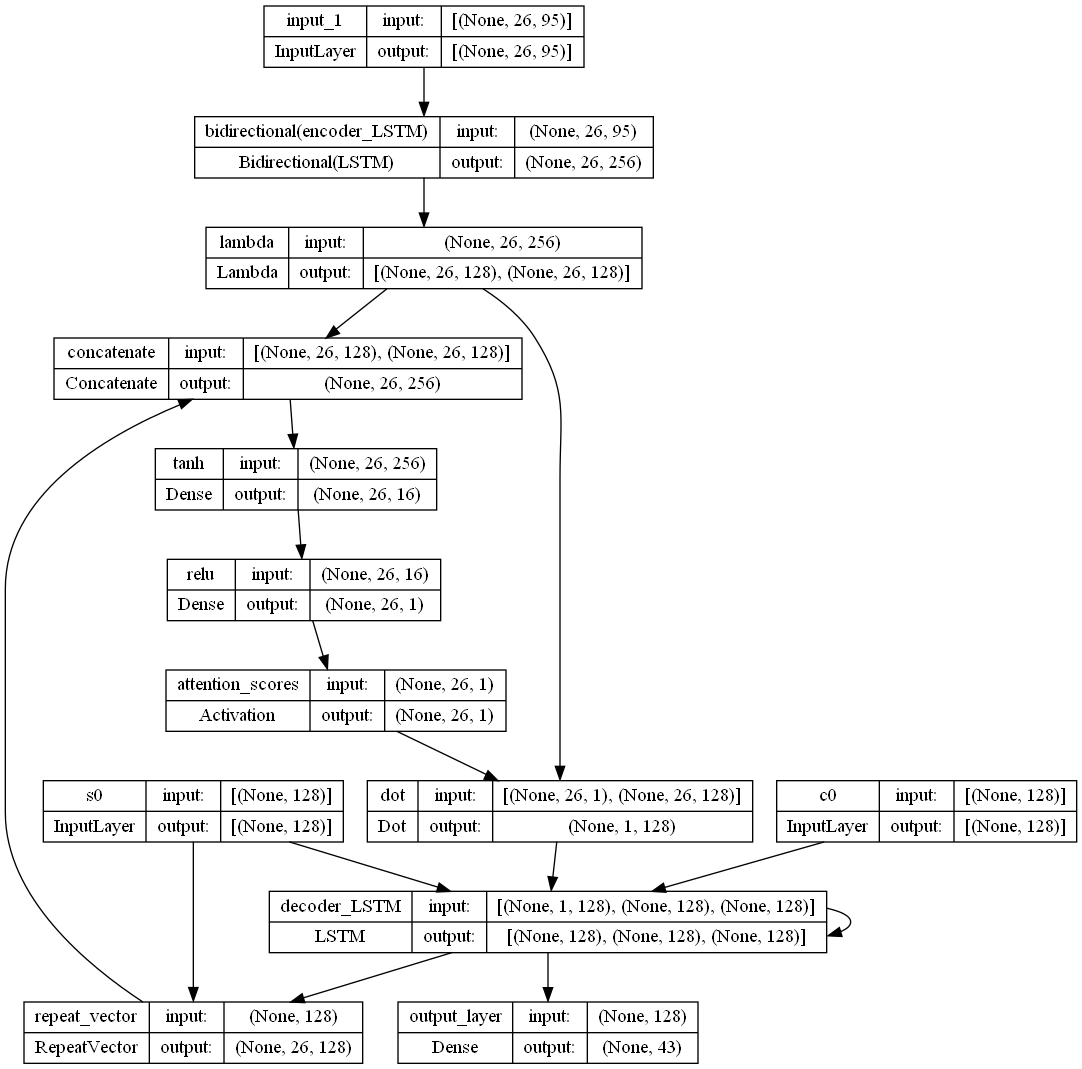

In [10]:
model = model(maxlenX, maxlenY, n_encode, n_decode, n_vocabInput, n_vocabOutput)
opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

### Model training

In [11]:
call_back = [TensorBoard(log_dir="./logs"), 
             EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='./model/checkpoint/', str='val_loss'), 
             ReduceLROnPlateau(monitor='val_loss', factor=0.9, min_lr=0.0001, patience=2)]

In [12]:
s0 = np.zeros((n_sample, n_decode))
c0 = np.zeros((n_sample, n_decode))
outputs = list(y.swapaxes(0,1))

In [13]:
# model.fit(x=[x, s0, c0], y=outputs, epochs=10, batch_size=32, validation_split=0.2, callbacks=call_back)
# model.save_weights(filepath="./model/self_attn_model.h5")
# model.save('./model/self_attn/')
model.load_weights(filepath="./model/self_attn_model.h5")

### Testing and Evaluation

##### import testin dataset

In [15]:
with open(os.path.join(path['test_dataset'], 'test_TH2IPA.json'), encoding="utf8") as f:
    test_TH2IPA = json.loads(f.read())

test_input = list(test_TH2IPA.keys())
test_target = list(test_TH2IPA.values())
print("number of testing sample: {}" .format(len(test_input)))

print(f"testing input: {test_input[0:10]}")
print(f"testing output: {test_target[0:10]}")

number of testing sample: 1370
testing input: ['ฮาร์ท', 'อาย', 'เอฟวรีติง', 'คอส', 'แอนด์', 'ดิท', 'แฟสท์', 'แฮด', 'ซาย', 'เพล']
testing output: ['ˈhɑɹt', 'ˈaɪ', 'ˈɛvɹiˌθɪŋ', 'ˈkɑz', 'ˈænd', 'ˈɪt', 'ˈfæst', 'ˈhæd', 'ˈaɪ', 'ˈpɫeɪ']


##### declare function

In [20]:
def printPrediction(input_x, y_pred, num_display=None):
    '''
    y_pred have to be the out put of model.predict function

    '''
    # convert the input to the model to Thai name in list
    input_name = convertModelInput2Char(input_x)

    # from the model output, the shape is incompatible so change the axis of array and using argmax to see where's the predict index
    prediction = np.swapaxes(y_pred, 0, 1)
    prediction = np.argmax(prediction, axis = -1)

    if num_display is not None:
        prediction = prediction[:num_display]
        input_name = input_name[:num_display]
    for idx in range(len(prediction)):
        output = "".join([idx2IPA[str(i)] for i in prediction[idx] if i!=0])
        print("{} : {}" .format(input_name[idx], output))

def prepareInput(input_list, return_label=False):
    x_encode = [list(map(lambda x: TH_char2idx[x], name)) for name in input_list]
    x_pad = pad_sequences(x_encode, maxlen=maxlenX, padding='post')
    x = to_categorical(x_pad, n_vocabInput)
    if(return_label):
        x_label = [list(map(lambda x: TH_idx2char[str(x)], name)) for name in x_pad]
        return x, x_label
    else:
        return x
    
def predictFromPronunciation(pron, model, display=False):
    x_test = convertChar2ModelInput(pron, model.input_shape[0][1], model.input_shape[0][2])
    s0 = np.zeros((len(pron), n_decode)) 
    c0 = np.zeros((len(pron), n_decode))
    y_pred = model.predict([x_test , s0, c0])

    if display:
        IPA = convertPred2IPA(y_pred)
        for i in range(len(IPA)):
            print("{} : {}" .format(pron[i], IPA[i]))

    return y_pred

def bleu_char_score(pred, target, n=4, weight=[0.25, 0.25, 0.25, 0.25], eps=1e-15):
    ''' the input is 1 word '''
    # assert len(pred)==len(target)
    n_pred = len(pred)
    n_target = len(target)
    if n_pred == 1 or n_target==1:
        n = 1
        weight = [1]
    elif n_pred == 2 or n_target==2:
        n = 2
        weight=[0.7, 0.3]
    elif n_pred==3 or n_target==3:
        n = 3
        weight=[0.4, 0.3, 0.3]
        
    sum_of_min = [0] * n ### index mean p_n_gram
    n_total_pred = [0] * n
    prob_i = [0] * n ### p_i each n_gram
    for i in range(n):
        pred_ngram = Counter(ngrams(pred, i+1))
        target_ngram = Counter(ngrams(target, i+1))
        n_total_pred[i] = sum(target_ngram.values())
        sum_of_min[i] = np.sum([min(pred_ngram[key], target_ngram[key]) for key in target_ngram.keys()])

    if n_pred > n_target:
        BP = 1
    else:
        ratio = n_target/n_pred
        BP = np.exp(1-ratio)
    
    # print(sum_of_min)
    # print(n_total_pred)
    # print(BP)
    # if 0 in n_total_pred:
    #     print(n_total_pred)
    #     print(pred, target)
    prob_i = np.divide(sum_of_min, n_total_pred)
    log_prob = np.log(prob_i+eps) ### add epsilon term
    BLEU = BP * np.exp(np.sum(weight*log_prob))
    #### the number of predict char and target char also the same length so I won't concern about Brevity Penalty
    return BLEU

def exact_char_match(pred_chars, target_chars):
    N_target_chars = len(target_chars)
    N_pred_chars = len(pred_chars)

    score = 0
    for index in range(min(N_pred_chars, N_target_chars)):
        if target_chars[index] == pred_chars[index]:
            score+=1
            
    return score / max(N_target_chars, N_pred_chars)

def evaluateModel(y_pred, y_test):
    bleu_score = []
    exact_match = []
    for pred, ref in zip(y_pred, y_test):
        bleu_score.append(bleu_char_score(pred, ref, weight=[0.7, 0.25, 0.04, 0.01]))
        exact_match.append(exact_char_match(pred, ref))
    print(f"Number of testing: {len(y_pred)}")
    print(f"Bleu score: {np.mean(bleu_score)}")
    print(f"Exact match score: {np.mean(exact_match)}")

    return bleu_score, exact_match

inferEncoder_model = inference_encoder(maxlenX, maxlenY, n_encode, n_decode, n_vocabInput, n_vocabOutput)
inferDecoder_model = inference_decoder(maxlenX, maxlenY, n_encode, n_decode, n_vocabInput, n_vocabOutput)
def plotAttention(word_list):
    n_word = len(word_list)
    max_n_char = len(max(word_list, key=len))
    
    x = [list(map(lambda x: TH_char2idx[x] if x in TH_char2idx.keys() else 1 , word)) for word in word_list]
    x_pad = pad_sequences(x, maxlenX, padding="post")
    x_categorical = to_categorical(x_pad, n_vocabInput)

    model_input = x_categorical.copy()
    word_label = [list(map(lambda x: TH_idx2char[str(x)], name)) for name in x_pad]

    s0 = np.zeros((n_word, n_decode))
    c0 = np.zeros((n_word, n_decode))
    s = s0
    c = c0
    # inferEncoder_model = inference_encoder(maxlenX, maxlenY, n_encode, n_decode, n_vocabInput, n_vocabOutput)
    # inferDecoder_model = inference_decoder(maxlenX, maxlenY, n_encode, n_decode, n_vocabInput, n_vocabOutput)

    h = inferEncoder_model.predict(model_input, verbose=0)

    output = list()
    attn_score = list()
    for t in range(maxlenY):
        out, s, c, attention_scores, energies = inferDecoder_model.predict([h, s, c], verbose=0)
        output.append(out)
        attn_score.append(attention_scores)

    # note: input and output length is the same
    output = np.swapaxes(output, 0, 1)
    output = np.argmax(output, axis = -1)
    output_label = [list(map(lambda x: idx2IPA[str(x)], name)) for name in output]
    attn_score = np.swapaxes(attn_score, 0, 1)
    # plt.figure(figsize=(20, 15))
    for i in range(n_word):
        # ax = plt.subplot(3, 2, i+1)
        # rows_name = output_label[i][:max_n_char]
        # cols_name = word_label[i][:max_n_char]
        # data = attn_score[i, :max_n_char, :max_n_char, 0]
        rows_name = output_label[i]
        cols_name = word_label[i]
        data = attn_score[i, :, :, 0]
        df = pd.DataFrame(data=data, index=rows_name, columns=cols_name)
        display(df)
        # sns.heatmap(df, vmin=0.0, vmax=1.0, cmap="magma")
        # plt.yticks(rotation=0)
    # plt.show()

##### Evaluate sample based MT

In [19]:
from nltk import edit_distance

def ThaiWord2IPA(th_word):
    try:
        IPA = TH2IPA[th_word]
    except KeyError:
        dict_key = list(TH2IPA.keys())
        min_distance_idx = np.argmin([edit_distance(key, th_word) for key in dict_key])
        fix_word = dict_key[min_distance_idx]
        IPA = TH2IPA[fix_word]
    if len(IPA) != 1:
        return [random.choice(IPA)]
    else:
        return IPA
    

test_pred = []
for thai_word in test_input:
    test_pred.extend(ThaiWord2IPA(thai_word))


bleu_score, em_score = evaluateModel(test_pred, test_target)

##### Evaluate neural MT

In [17]:
y_pred = predictFromPronunciation(test_input, model)
test_pred = convertPred2IPA(y_pred)

bleu_score, em_score = evaluateModel(test_pred, test_target)

43/43 [==============================] - 16s 63ms/step
Number of testing: 1370
Bleu score: 0.8741540043294739
Exact match score: 0.9159124877555535


##### visualize with dataframe

In [18]:
import pandas as pd

data = {'input':test_input, 'predict': test_pred, 'ground truth':test_target, 'bleu_score': bleu_score, 'em_score': em_score}
df = pd.DataFrame(data)
mean = df['bleu_score'].mean()
sd = df['bleu_score'].std()

low_score_df = df.loc[df['bleu_score']<mean-sd].sort_values(by=['bleu_score'])
low_score_df.head(300)

,input,predict,ground truth,bleu_score,em_score
793,ดอน,ˈɑn,ˈdɔn,5.430292e-10,0.250000
1343,เอาเออ,ˈðʊ,ˈaʊɝ,5.430292e-10,0.500000
252,อ๊อฟ,ˈəv,ˈɔf,6.443940e-10,0.333333
655,วู,ˈwu,ˈhu,8.502830e-10,0.666667
38,เดอะ,ˈeə,ˈðə,8.502830e-10,0.666667
...,...,...,...,...,...
1332,แพลทเนิม,ˈpɫænəm,ˈpɫætənəm,5.320888e-01,0.555556
55,อันเดอร์คัฟเวอร์,ˈəndɝˈfwɝɝ,ˌəndɝˈkəvɝ,5.422266e-01,0.600000
918,เฮโรอิน,ˈhɛɹɹɹnɪn,ˈhɛɹoʊən,5.483366e-01,0.444444
1352,ฟิกซิง,ˈfɪssɪŋ,ˈfɪksɪŋ,5.536010e-01,0.857143


In [21]:
high_score_df = df.loc[df['bleu_score']>mean-sd].sort_values(by=['bleu_score'], ascending=False)
high_score_df.head(5)

,input,predict,ground truth,bleu_score,em_score
0,ฮาร์ท,ˈhɑɹt,ˈhɑɹt,1.0,1.0
878,ออวโมส,ˈɔɫˌmoʊst,ˈɔɫˌmoʊst,1.0,1.0
884,บิลิฝ,bɪˈɫiv,bɪˈɫiv,1.0,1.0
883,ลิป,ˈɫɪps,ˈɫɪps,1.0,1.0
882,เมาท์,ˈmaʊθ,ˈmaʊθ,1.0,1.0


##### Plot attn with dataframe (can not plot heat map with IPA symbol)

In [22]:
low_word = low_score_df['input'].values[:5]
plotAttention(low_word)

,ด,อ,น,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.985811,0.000545,0.000545,0.001115,0.000545,0.000545,0.000545,0.000545,0.000545,0.000545,...,0.000545,0.000545,0.000545,0.000545,0.000545,0.000545,0.000545,0.000545,0.000545,0.000545
ɑ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
n,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,เ,อ,า,เ,อ,อ,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.919097,0.000243,0.000243,0.025584,0.000243,0.000243,0.013275,0.036705,0.000243,0.000243,...,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243
ð,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ʊ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,อ,๊,อ,ฟ,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.896858,0.000371,0.082155,0.000360,0.015326,0.000235,0.000235,0.000235,0.000235,0.000235,...,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235
ə,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
v,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,ว,ู,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.983924,0.000326,0.000326,0.000326,0.008252,0.000326,0.000326,0.000326,0.000326,0.000326,...,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326,0.000326
w,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
u,0.045999,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,...,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160,0.038160
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,เ,ด,อ,ะ,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.845194,0.000223,0.000223,0.000387,0.140129,0.009381,0.000223,0.000223,0.000223,0.000223,...,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
e,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ə,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


In [23]:
high_score_low_word = high_score_df['input'].values[:5]
plotAttention(high_score_low_word)

,ฮ,า,ร,์,ท,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.974674,0.001183,0.017672,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,...,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281
h,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ɑ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ɹ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
t,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.039944,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,...,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402,0.038402
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,อ,อ,ว,โ,ม,ส,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.868885,0.000227,0.046339,0.000227,0.000227,0.000227,0.006495,0.073276,0.000227,0.000227,...,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227
ɔ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ɫ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ˌ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
m,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
o,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ʊ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
s,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
t,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,บ,ิ,ล,ิ,ฝ,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
b,0.990040,0.000387,0.000387,0.000483,0.000578,0.000387,0.000387,0.000387,0.000387,0.000387,...,0.000387,0.000387,0.000387,0.000387,0.000387,0.000387,0.000387,0.000387,0.000387,0.000387
ɪ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ˈ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ɫ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
i,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
v,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,ล,ิ,ป,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.989295,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,...,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428
ɫ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ɪ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
p,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
s,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462


,เ,ม,า,ท,์,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,...,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
ˈ,0.992706,0.000262,0.000262,0.000262,0.001004,0.000262,0.000262,0.000262,0.000262,0.000262,...,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262,0.000262
m,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
a,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
ʊ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
θ,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
<PAD>,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,...,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462
